In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse as sp
from scipy.sparse import linalg as LA
from matplotlib.animation import FuncAnimation

In [2]:
h_0 = 0.01
tau = h_0 / 10

q = 50
beta = 0.9
nu = 0.5

start_x, start_y = -1, -1
stop_x, stop_y = 1, 1
l_x = stop_x - start_x
l_y = stop_y - start_y
n_x, n_y = int(np.round(l_x / h_0)), int(np.round(l_y / h_0))
h_x, h_y = l_x / n_x, l_y / n_y
x = np.linspace(start_x +  h_x / 2, stop_x - h_x / 2, n_x)
y = np.linspace(start_y + h_y / 2, stop_y - h_y / 2, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')

In [3]:
def f(x, y):
    return np.zeros_like(x)

def phi_l(y: np.array):
    return np.heaviside(h_y - y, 0) * np.heaviside(y + h_y, 0) * q + \
           np.heaviside(l_y/4 + h_y - y, 0) * np.heaviside(y - l_y/4 + h_y, 0) * q + \
           np.heaviside(-l_y/4 + h_y - y, 0) * np.heaviside(y + l_y/4 + h_y, 0) * q

def phi_r(y: np.array):
    return np.heaviside(h_y - y, 0) * np.heaviside(y + h_y, 0) * q + \
           np.heaviside(l_y/4 + h_y - y, 0) * np.heaviside(y - l_y/4 + h_y, 0) * q + \
           np.heaviside(-l_y/4 + h_y - y, 0) * np.heaviside(y + l_y/4 + h_y, 0) * q

def phi_b(x: np.array):
    return np.heaviside(h_x - x, 0) * np.heaviside(x + h_x, 0) * q + \
           np.heaviside(l_x/4 + h_x - x, 0) * np.heaviside(x - l_x/4 + h_x, 0) * q + \
           np.heaviside(-l_x/4 + h_x - x, 0) * np.heaviside(x + l_x/4 + h_x, 0) * q

def phi_t(x: np.array):
    return np.heaviside(h_x - x, 0) * np.heaviside(x + h_x, 0) * q + \
           np.heaviside(l_x/4 + h_x - x, 0) * np.heaviside(x - l_x/4 + h_x, 0) * q + \
           np.heaviside(-l_x/4 + h_x - x, 0) * np.heaviside(x + l_x/4 + h_x, 0) * q


In [4]:
def RHS(X, Y, h_x, h_y):
    res = f(X, Y)
    res[0, :] += phi_l(Y[0, :]) / h_x
    res[-1, :] += phi_r(Y[-1,:]) / h_x
    res[:, 0] += phi_b(X[:, 0]) / h_y
    res[:, -1] += phi_t(X[:, -1]) / h_y
    return res

In [5]:
def OpL(nx, ny, hx, hy):
    k = np.arange(nx * ny, dtype=int).reshape((nx, ny)) 

    L = sp.lil_matrix((nx * ny, nx * ny))

    for i in range(nx):
        for j in range(ny):
            if i == 0:
                # нейман лево
                L[k[i,j], k[i, j]] += 1.0/ hx ** 2
                L[k[i, j], k[i + 1, j]] = -1.0/ hx ** 2
            elif i == nx - 1:
                # нейман право
                L[k[i, j], k[i, j]] += 1.0 / hx ** 2
                L[k[i, j], k[i - 1, j]] =  -1.0 / hx ** 2
            else:
                # центральные ячейки
                L[k[i, j], k[i, j]] += 2.0 / hx ** 2
                L[k[i, j], k[i - 1,j]] = -1.0 / hx ** 2
                L[k[i, j], k[i + 1, j]] = -1.0 / hx ** 2
            if j == 0:
                # нейман низ
                L[k[i, j], k[i, j]] += 1.0 / hy ** 2
                L[k[i,j], k[i, j + 1]] = -1.0 / hy ** 2
            elif j == ny - 1:
                # нейман верх
                L[k[i, j], k[i, j]] += 1.0 / hy ** 2
                L[k[i,j], k[i, j - 1]] = -1.0 / hy ** 2
            else:
                # центральные ячейки
                L[k[i, j], k[i, j]] += 2.0 / hy ** 2
                L[k[i,j], k[i, (j - 1) % ny]] = -1.0 / hy ** 2
                L[k[i, j], k[i, (j + 1) % ny]] = -1.0 / hy ** 2

            L[k[i, j], k[i, j]] += 4
            # экран

    return L.tocsr()


In [6]:
L = OpL(n_x, n_y, h_x, h_y)
F = RHS(X, Y, h_x, h_y).flatten()
A = sp.eye(n_x * n_y, format='csr') + tau * nu * L
B = sp.eye(n_x * n_y, format='csr') - tau * (1 - nu) * L
C = tau * F

u = np.zeros(n_x * n_y)
T = 5
vmin = 0.5
vmax = 2

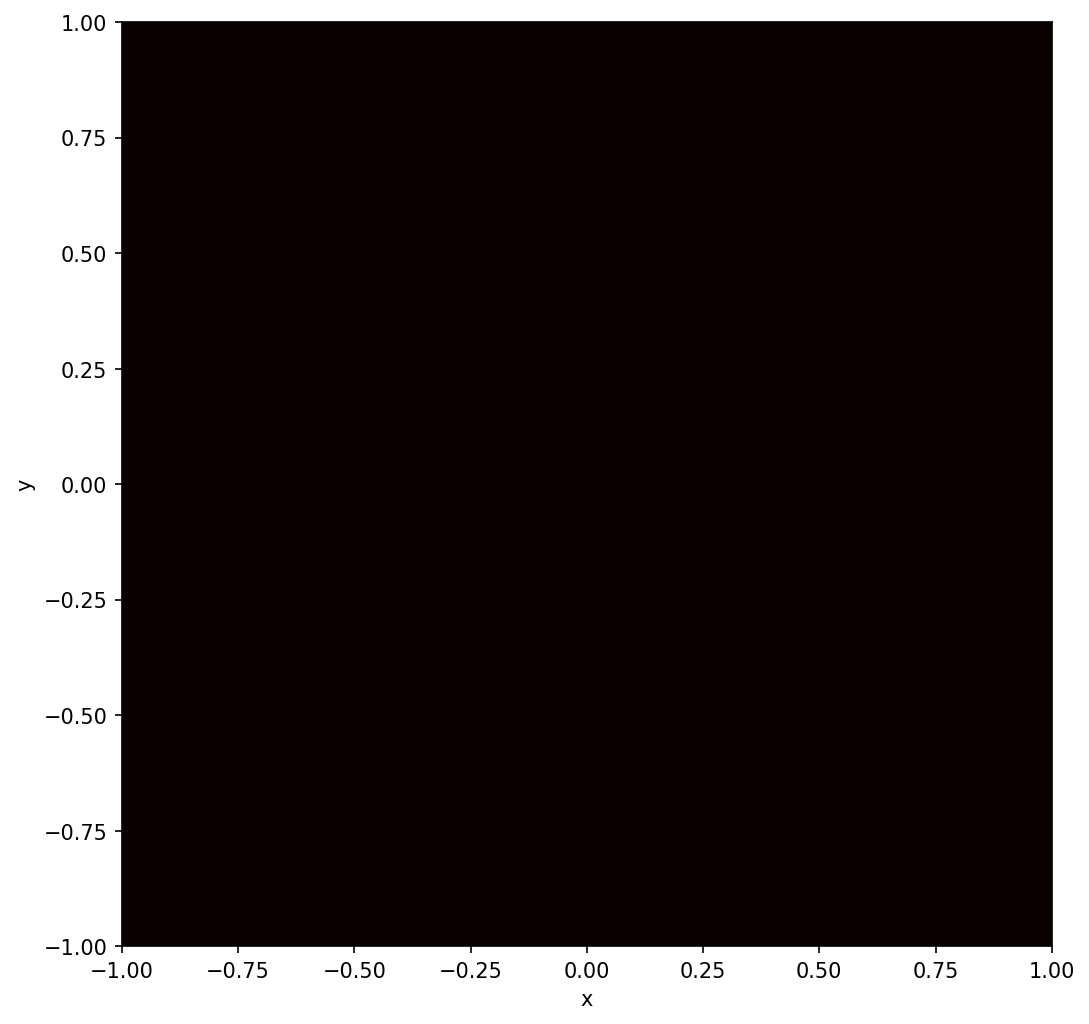

In [9]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
heatmap = ax1.imshow(u.reshape(n_x, n_y).T, origin='lower', cmap='hot', \
               extent=(start_x, stop_x, start_y, stop_y), aspect='auto', vmin=vmin, vmax=vmax)

def update(frame):
    global u
    u = LA.cg(A, B @ u + C, x0=u)[0]
    heatmap.set_array(u.reshape(n_x, n_y).T)
    ax1.set_title(f"Концентрация изотопа t = {frame * tau}")
    return [heatmap]

ani = FuncAnimation(fig, update, frames=int(T / tau), interval=5)

plt.show()
_ = ani  